# TD 6 - 26th of Jan. 2024

Faisal Jayousi: jayousi@unice.fr

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import norm

## Forward model: the blurring operator

In SMLM type data, the acquisition consist of a blurred and noisy image of a molecule sample (the ground truth image). 
Let $x\in\mathbb R^n$ be the ground truth image. The microscope's limitations only permit access to a blurred and noisy version $$y=Ax+\eta$$
where $A:\mathbb R^n \longrightarrow \mathbb R^n$ is the forward blurring operator and $\eta\in\mathbb R^n$ is a Gaussian distributed noisy vector with $0$ mean and variance $\sigma^2$: $\eta\sim\mathcal N(0,\sigma^2)$.

Given the acquisition $y$, we aim to reconstruct the ground truth $x$. To do so, a thorough understanding of the microscope's functioning is required, and a corresponding forward model must be proposed.

* Load the ground truth image.

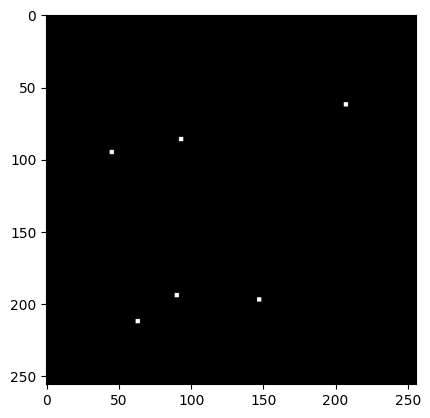

In [2]:
# load the image
gt = plt.imread('gt.png')
gt = gt[..., 1]
gt = gt * 255.

# plot the image
plt.imshow(gt, cmap='gray')
plt.show()

We will now focus on the blurring operator. Recall that it is inconvenient (and often impossible) to construct the matrix $A$. Multiplying an image with a blurring matrix (huge) can be written as a convolution between the image itself and an appropriate kernel (that has the same size as the image), called Point Spread Function (PSF), since it describes how a point is distorted (and spread) by the microscope. To do so, the Fast Fourier Trasform is used and only the PSF has to be stored.

* Let $\sigma_h=20$. Create the associated Gaussian kernel $h$.

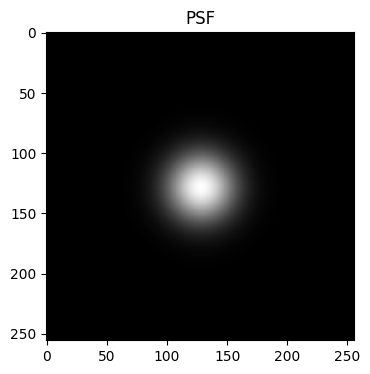

In [3]:
# convolution kernel: the point spread function PSF
s = 20
n = gt.shape[0]
t = np.concatenate( ( np.arange(0, n/2+1), np.arange(-n/2, -1)))

Y, X = np.meshgrid(t,t)
h = np.exp(-(X**2+Y**2)/(2.0*float(s)**2))
h = h / np.sum(h)

plt.figure(figsize=(4, 4))
plt.imshow(np.fft.fftshift(h), cmap='gray')
plt.title('PSF')
plt.show()

In [4]:
# define the forward operator using the convolution theorem
def forward_operator(x, h):
    hf = np.real(np.fft.fft2(h)) 
    blur = np.real(np.fft.ifft2(hf*np.fft.fft2(x)))
    return blur

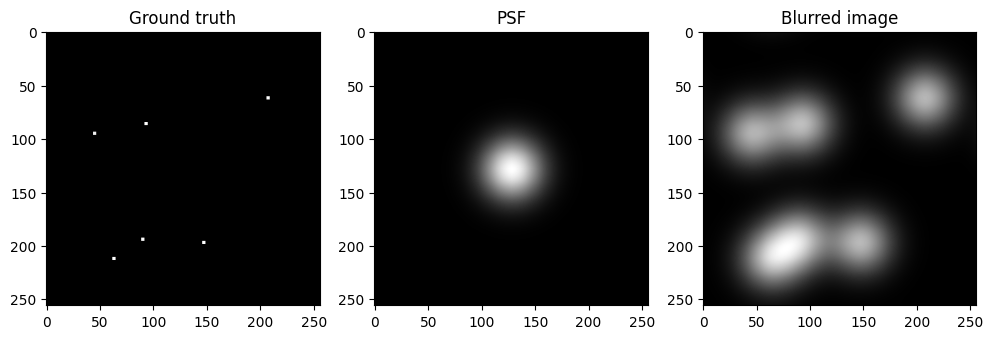

In [5]:
# compute the blurred imaage
blurred_image = forward_operator(gt, h)

# plot the ground truth, the PSF and the blurred image
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(gt, cmap='gray')
plt.title('Ground truth')
plt.subplot(132)
plt.imshow(np.fft.fftshift(h), cmap='gray')
plt.title('PSF')
plt.subplot(133)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred image')
plt.show()

Now we need to generate a noisy realisation of the blurred image in order to obtain a realistic acquisition. Add some Gaussian noise with $\sigma=0.1$.

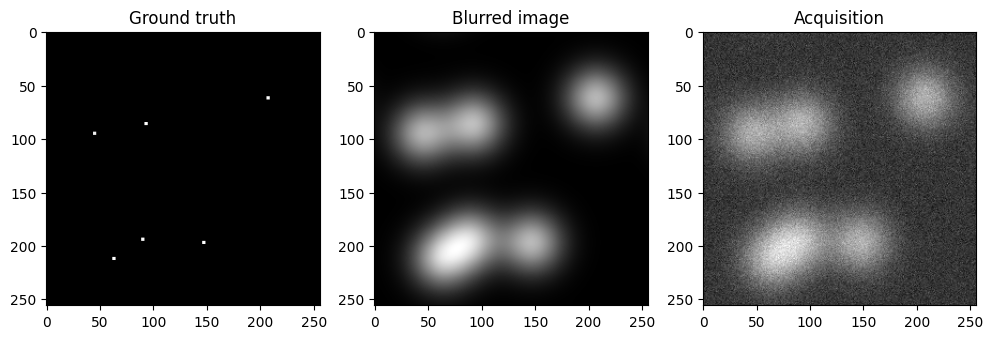

In [6]:
# in this way you will have a deterministic result
np.random.seed(24)

sigma_noise = 0.1
acq = blurred_image + sigma_noise * np.random.randn(*np.shape(blurred_image))

# plot the ground truth, the blurred image and the final acquisition (blurred and noisy)
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(gt, cmap='gray')
plt.title('Ground truth')
plt.subplot(132)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred image')
plt.subplot(133)
plt.imshow(acq, cmap='gray')
plt.title('Acquisition')
plt.show()

## Implementation of the Forward-Backward algorithm (ISTA)

Let $y\in\mathbb R^n$ be a noisy acquisition and $A:\mathbb R^n \longrightarrow \mathbb R^n$ the blurring operator. To solve the inverse problem i.e. to find $x\in\mathbb R^n$ such that $$y=Ax+\eta$$ We use a variational approach and solve
$$ \operatorname{argmin}_{x\in\mathbb R^n} \frac{1}{2}\|Ax-y\|_2^2+\lambda \|x\|_1+\texttt{i}_{\ge 0}(x) $$
with the Forward-Backward algorithm. The first step of FB algorithm is the forward step: a gradient descent step for the smooth function $f$. 

Implement a function that computes the gradient of $f$, $\nabla f(x)= A^T (Ax-y)$.

In [7]:
# define the gradient of the fidelity term in terms of convolutions
def gradient(x, h, y):
    aus = forward_operator(x,h) - y
    return np.real(np.fft.ifft2(np.conj(np.fft.fft2(h)) * np.fft.fft2(aus))) # don't forget to take the real part (np.real())!

Compute now the Lipschitz constant of $\nabla f$, recalling that $L=\|A\|^2$. This will be needed for choosing a suitable stepsize.

In [8]:
# compute the Lipschitz constant Lips
hf = np.real(np.fft.fft2(np.fft.fftshift(h)))
Lips = np.max(hf**2)

Define the soft thresholding function below. This function is needed during the backward step.

In [9]:
# prox of \ell_1 norm: soft thresholding function
def soft_thresholding(x, gamma):
    return np.sign(x) * np.maximum(0, np.abs(x) - gamma)


Implement a function that computes the fidelity term $f(x)=\frac{1}{2}\|Ax-y\|_2^2$ and the cost function $F(x)=\frac{1}{2}\|Ax-y\|_2^2+\lambda \|x\|_1$  at each point.

In [10]:
# fidelity
def fidelity(x, h, y):
    Ax = forward_operator(x, h)
    fidelity = 1/2 * np.linalg.norm(Ax-y)**2
    return fidelity


# cost function
def cost_function(x, h, y, lmbda):
    return fidelity(x, h, y) + lmbda*np.linalg.norm(x, 1)


You have now the elements to define the function for the FB algorithm.

In [11]:
# input parameters
# x0 is the initialisation
# tau is the stepsize
# lambda is the regularisation parameter
# y is the acquisition, h is the psf ---> needed to compute the gradient of f at each iteration
# epsilon is the tolerance parameter, maxiter is the maximum numer of iterations ---> needed for the stopping criterion

def FB(x0, tau, lmbda, y, h, epsilon, maxiter):
    xk = x0
    cost = np.zeros(maxiter)
    norms = np.zeros(maxiter)

    for k in np.arange(maxiter):

        if (k + 1) % 100 == 0:
            print(f'Iter {k+1}/{maxiter}')
        # forward step: gradient descent of f
        xkk = xk - tau * gradient(xk, h, y)

        # backward step
        xkk = soft_thresholding(xkk, tau*lmbda)

        # positivity constraints
        xkk = np.maximum(0, xkk)

        # compute the cost function
        cost[k] = cost_function(xkk, h, y, lmbda)
        norms[k] = np.linalg.norm(xkk-xk, 'fro')

        # update the iteration
        xk = xkk
        if np.abs(cost[k] - cost[k-1]) / cost[k] < epsilon:
            break
    return xk , cost, norms

Useful: define a function to plot reconstruction, cost function and relative changes of the iterates.

In [12]:
def plot_results(rec, cost, norms):
    # plot the ground truth, the final acquisition (blurred and noisy) and the reconstruction
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(gt, cmap='gray')
    plt.title('Ground truth')
    plt.subplot(132)
    plt.imshow(acq, cmap='gray')
    plt.title('Acquisition')
    plt.subplot(133)
    plt.imshow(rec, cmap='gray')
    plt.title('Reconstruction')
    plt.show()

    # plot how the cost function decreases and how the iterates converge
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(cost)
    plt.xlabel('$k$')
    plt.ylabel("$F(x_k)$")
    plt.title('Cost function')
    plt.subplot(122)
    plt.plot(norms)
    plt.xlabel('$k$')
    plt.ylabel("$||x^{(k+1)}-x_{k}||$")
    plt.title('Relative difference in the reconstructions')
    plt.show()

Check that your algorithm is working by computing the reconstruction for the following set of input parameters.

Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


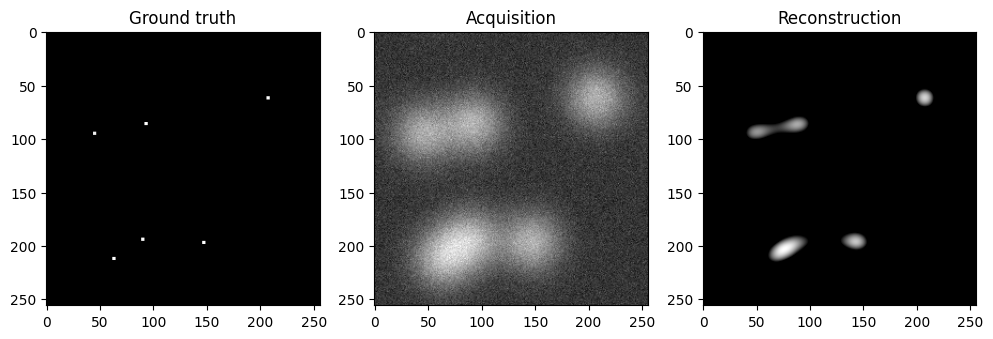

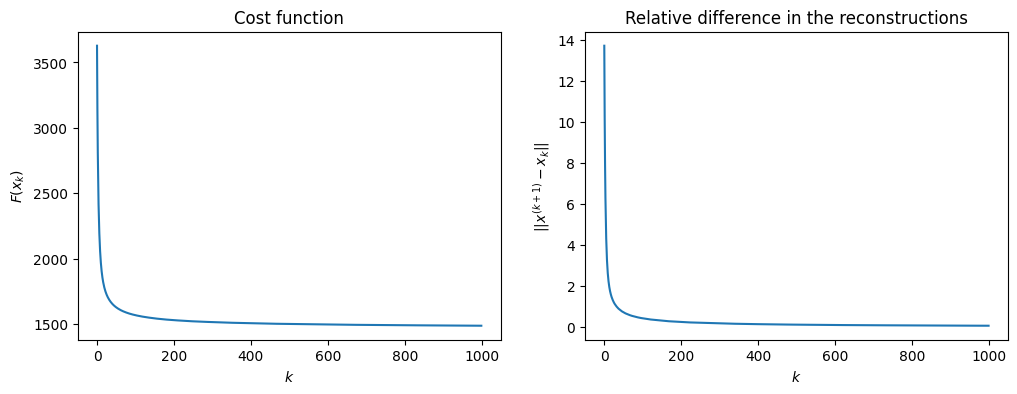

In [13]:
n = np.shape(gt)[0]
dim = (n, n)
x0 = np.zeros(dim)
tau = 0.5
lmbda = 0.3
maxiter = 1000
epsilon = 0.001


# compute the reconstruction
rec, cost, norms = FB(x0, tau, lmbda, acq, h, 0, maxiter)
plot_results(rec, cost, norms)

## Questions: regularisation parameter

1) Try different values of the regularisation parameter and see what happens. Can you explain the behaviour of the reconstructions with respect to $\lambda$? Does the choice of $\lambda$ affect the reconstruction?

\lambda=0.001
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


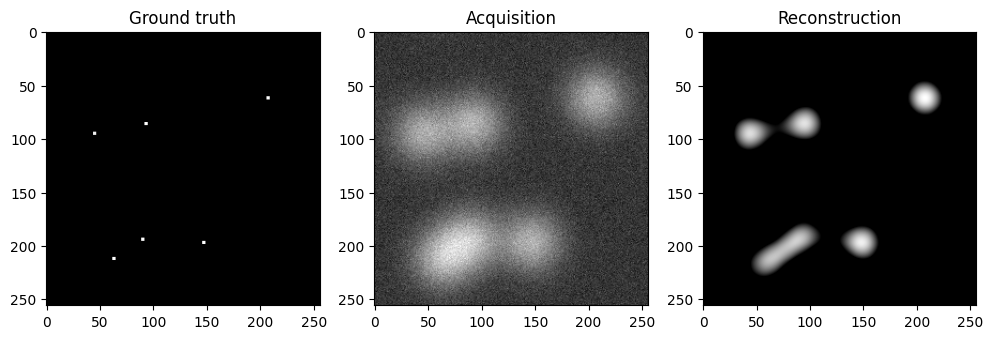

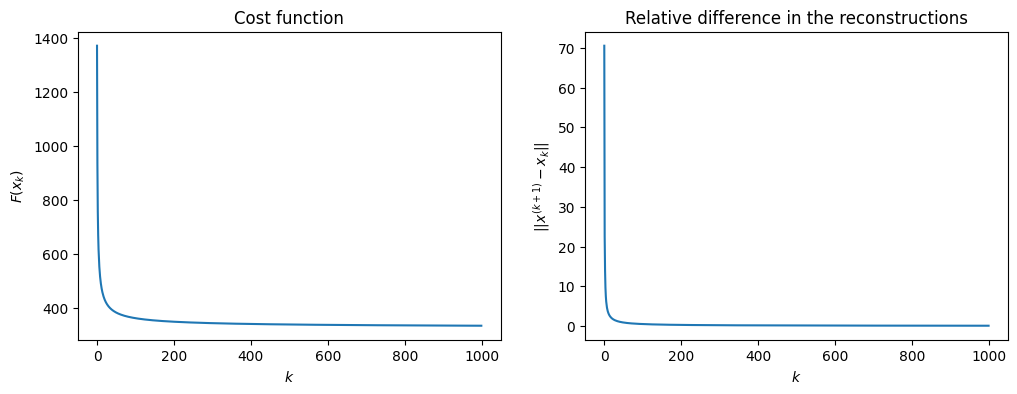

\lambda=0.01
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


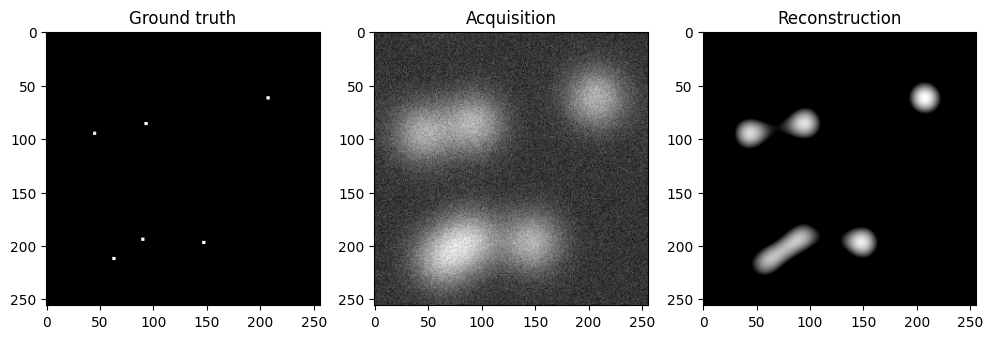

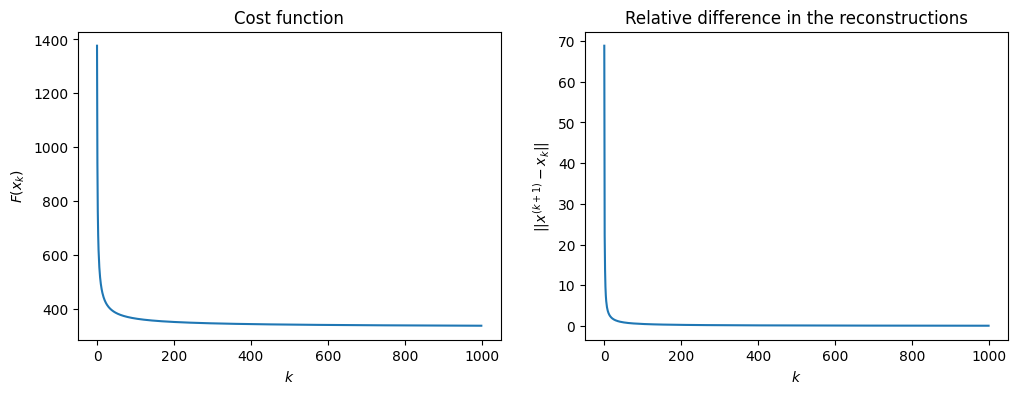

\lambda=0.05
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


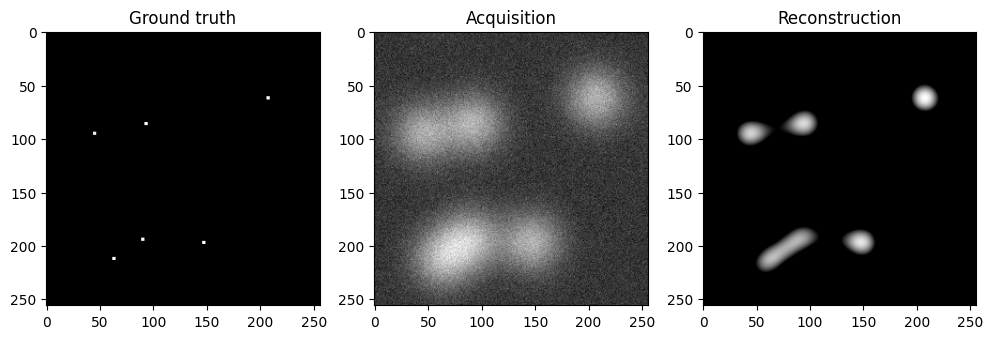

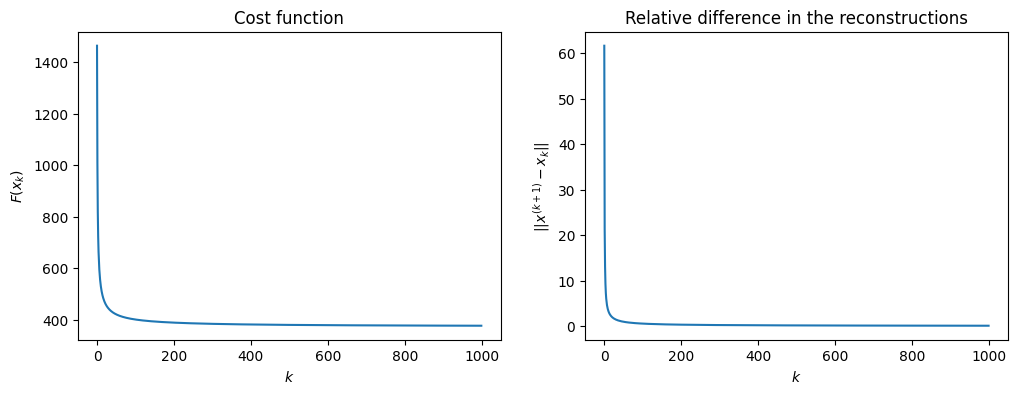

\lambda=0.1
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


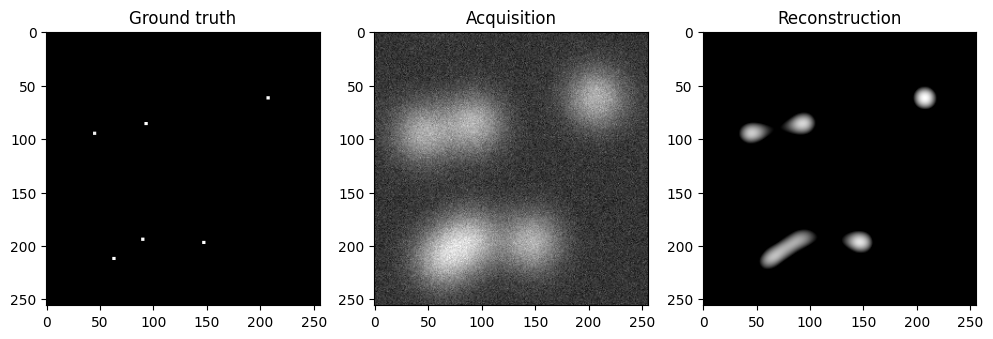

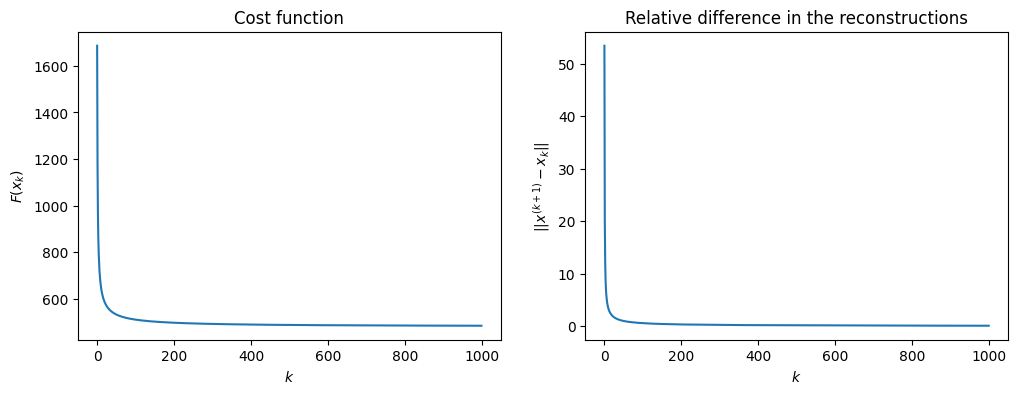

\lambda=0.3
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


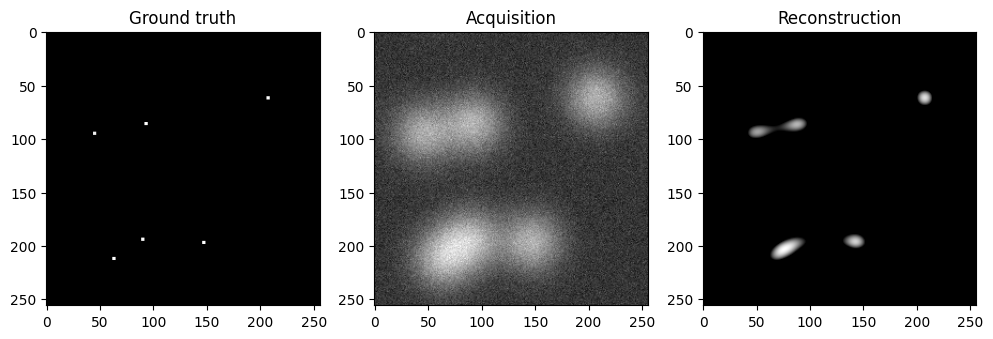

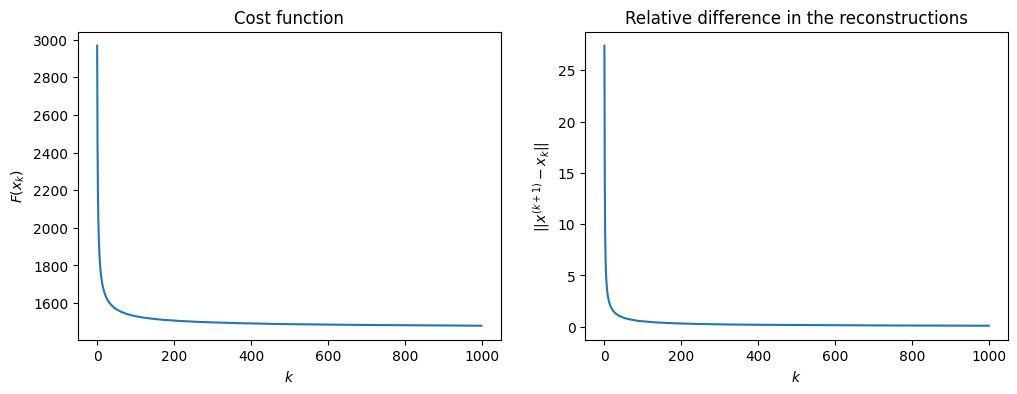

\lambda=0.5
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


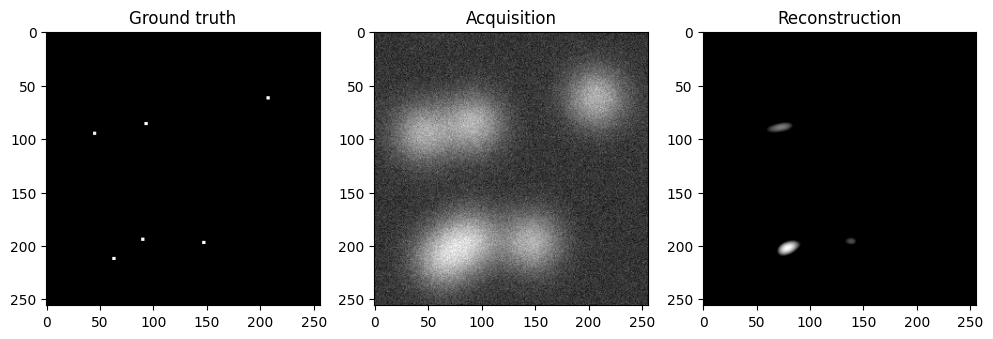

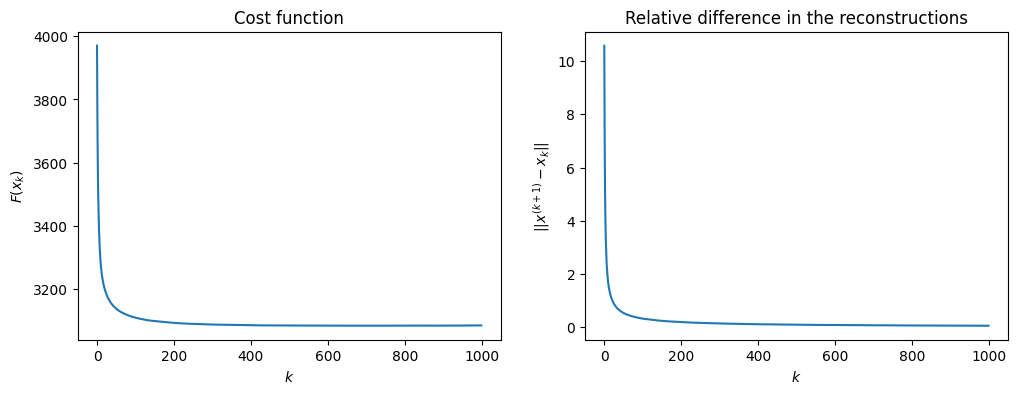

\lambda=1
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


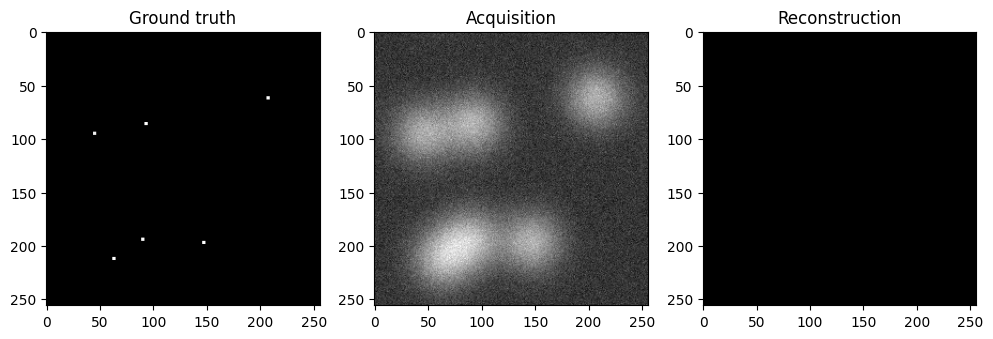

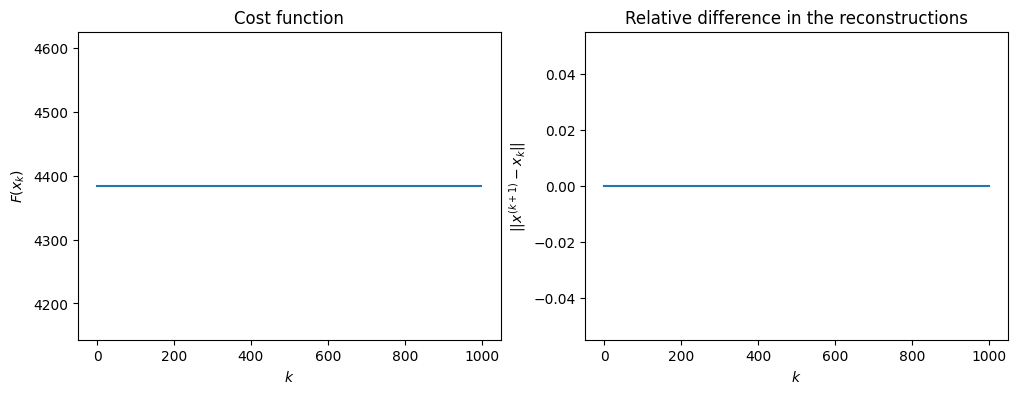

In [14]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 1
maxiter = 1000
epsilon = 0

# choose some values for lmbda
lmbda = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 1]

# compute the reconstruction
for l in lmbda:
    print(f'\lambda={l}')
    rec, cost, norms = FB(x0, tau, l, acq, h, epsilon, maxiter)
    plot_results(rec, cost, norms)

> The choice of the regularization parameter $\lambda$ significantly influences the reconstruction process. When $\lambda$ is small, the regularization effect is minimal, resulting in a reconstruction that closely resembles the noisy or distorted input data. This can lead to overfitting, where the reconstructed image captures noise and artifacts rather than the underlying structure of interest.
>
> Conversely, for large values of $\lambda$, the regularization effect becomes dominant, potentially suppressing important features of the reconstructed image. In extreme cases, when $\lambda$ is excessively large, the reconstructed image become nearly uniform or completely zeroed out, failing to capture any meaningful information from the input data.
>
> Hence, selecting an appropriate value for $\lambda$ is crucial. It should strike a balance between preserving important details and suppressing noise and artifacts.

2) For example try $\lambda=0$. What happens? Which algorithm are you actually using in this very particular case? (Look both at the reconstructed image and at the equation defining the model with $\lambda=0$)

Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


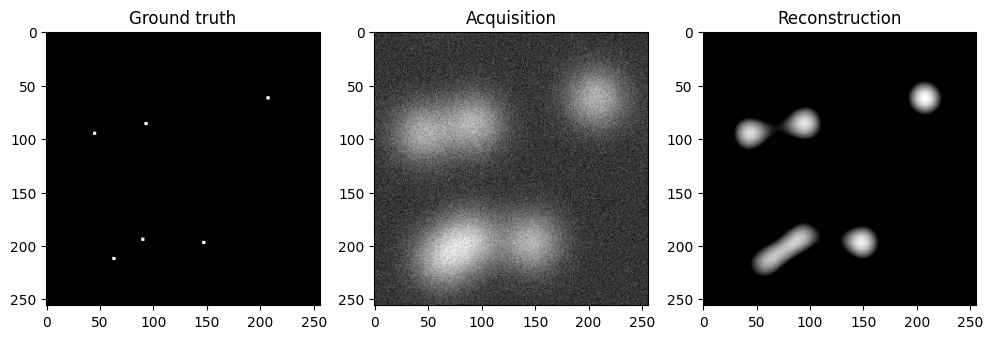

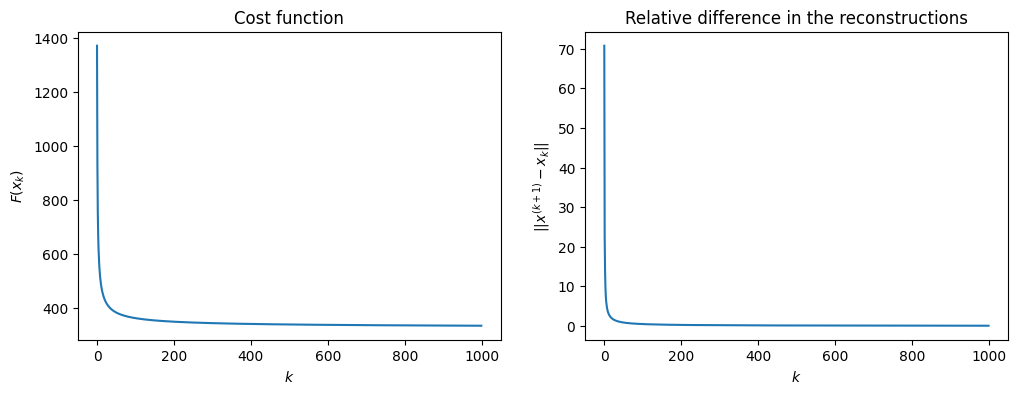

In [15]:
rec, cost, norms = FB(x0, tau, 0, acq, h, epsilon, maxiter)
plot_results(rec, cost, norms)


> When $\lambda = 0$ the regularization term vanishes, leading to a reconstruction outcome akin to those attained with very small values of $\lambda$, where regularization plays a minimal role.
> The optimization problem:
> $$ \operatorname{argmin}_{x\in\mathbb R^n} \frac{1}{2}\|Ax-y\|_2^2+\lambda \|x\|_1+\texttt{i}_{\ge 0}(x) \qquad (1)$$
> with $\lambda = 0$ simplifies to: 
> $$ \operatorname{argmin}_{x\in\mathbb R^n} \frac{1}{2}\|Ax-y\|_2^2+\texttt{i}_{\ge 0}(x) \qquad (2).$$
> We approach the original problem using the ISTA algorith, However, in the case of $\lambda = 0$, the proximal step associated with the penalty term vanishes, leaving us with only the gradient descent step and the projection onto the non-negative orthant.


## Questions: step-size
To answer the following questions set $\lambda=0.3$, $maxiter = 1000$, $\epsilon = 0$ and $x_0=0$.

3) Try a very small stepsize and observe how the cost function decreases.

Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


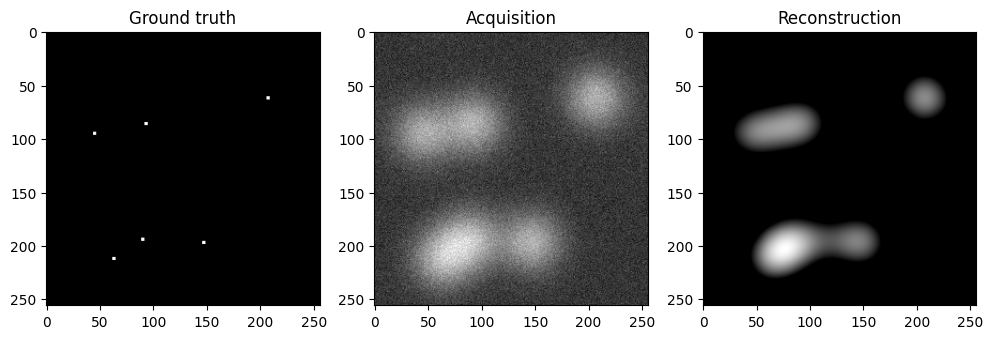

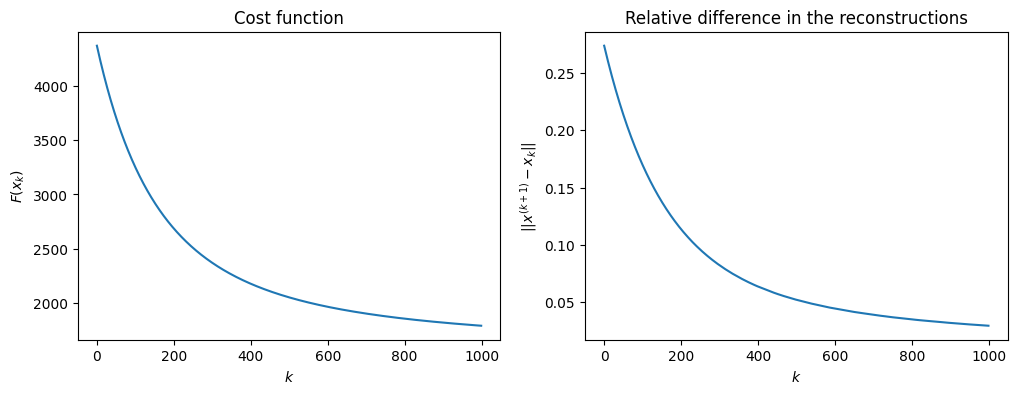

In [16]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 0.01
maxiter = 1000
epsilon = 0
lmbda = 0.3

rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter)
plot_results(rec, cost, norms)

> It converges more gently than when the step size is 0.5. And, the reconstruction image is still very blurred after 1000 iterations.

4) Then try $\tau=\frac{1}{Lips}$. What do you observe? 

Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


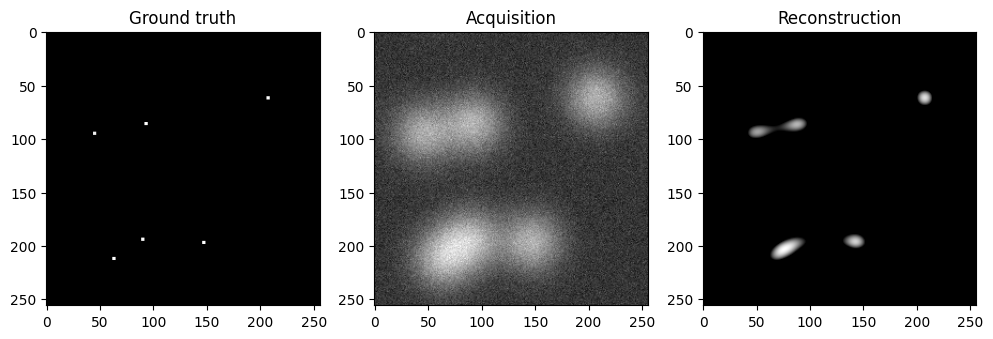

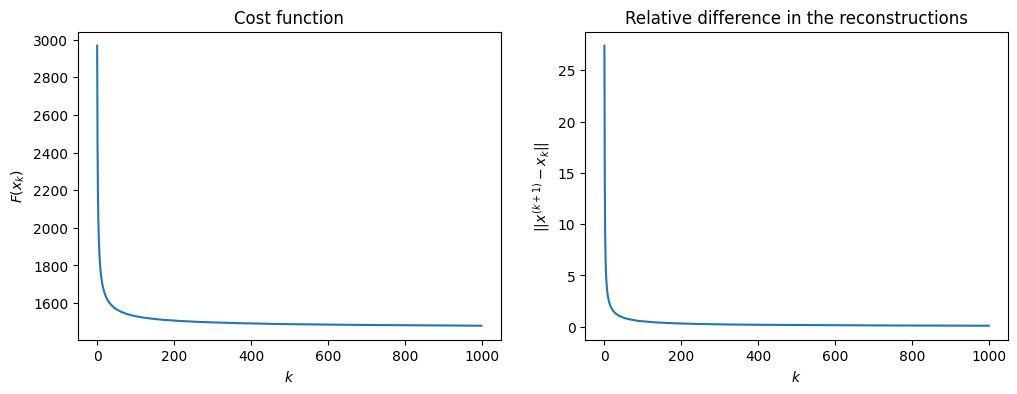

In [17]:
dim = (n, n)
x0 = np.zeros(dim)
tau =  1/Lips
maxiter = 1000
epsilon = 0
lmbda = 0.3

rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter)
plot_results(rec, cost, norms)

> It converges dramatically than before, and we we can get the optimal image with converged cost.

5) Then try $\tau>>\frac{1}{Lips}$. What do you observe? 

(Hint: plot the cost functions in the three cases)

Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


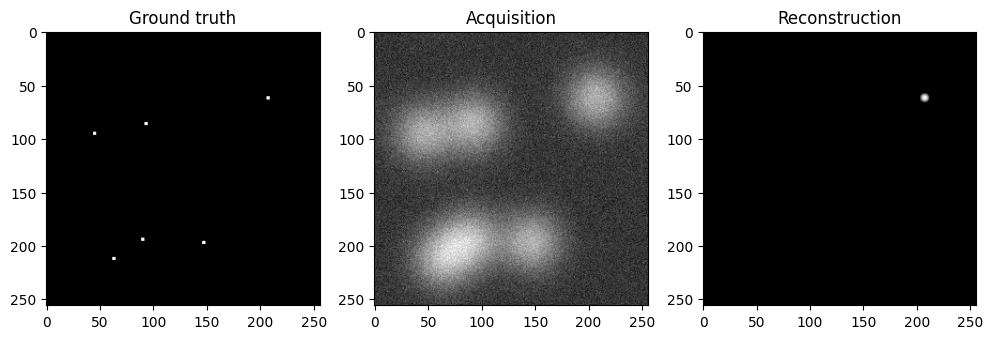

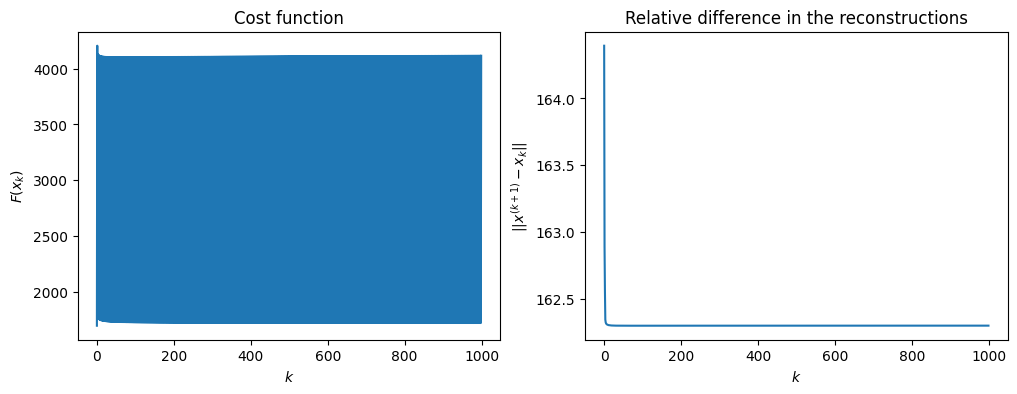

In [18]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 1/Lips + 5
maxiter = 1000
epsilon = 0
lmbda = 0.3


rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter)
plot_results(rec, cost, norms)

> When $\tau>>1/Lips$, the cost function fails to decrease smoothly; instead, it oscillates. This phenomenon occurs because the step size is excessively large, causing the algorithm to "jump" back and forth across the convex function at each iteration. Consequently, the algorithm struggles to converge to the minimum point as it overshoots and undershoots repeatedly.

## Towards more complex regularisation functions
We now consider the following optimisation problem $$ \min_{x\in\mathbb R^n} \frac{1}{2}\|Ax-y\|_2^2+\lambda\mathcal{R}_{\alpha,\beta}(x)+\texttt{i}_{\ge 0}(x) $$
where $$\mathcal{R}_{\alpha,\beta}(x) = \|x\|_1+\langle\alpha,x\rangle+\beta, \qquad \alpha\in\mathbb{R}^n, \beta>0$$
* Complete the functions below

In [19]:
def new_prox(x, tau, alpha):
    """
    prox operator of R(x)
    """
    return soft_thresholding(x - tau*alpha, tau) 

def new_cost_function(x, h, y, lmbda, alpha, beta):
    return fidelity(x, h, y) + lmbda * (np.linalg.norm(x, 1) + np.sum(np.dot(alpha,x)) + beta)

* Modify the FB function accordingly

In [20]:
def FB(x0, tau, lmbda, y, h, epsilon, maxiter, alpha, beta):
    xk = x0
    cost = np.zeros(maxiter)
    norms = np.zeros(maxiter)

    for k in np.arange(maxiter):

        if (k + 1) % 100 == 0:
            print(f'Iter {k+1}/{maxiter}')
            
        # forward step: gradient descent of f
        xkk = xk - tau * gradient(xk, h, y)

        # backward step
        xkk = new_prox(xkk, tau*lmbda, alpha)

        # positivity constraints
        xkk = np.maximum(0, xkk)

        # compute the cost function
        cost[k] = new_cost_function(xkk, h, y, lmbda, alpha, beta)
        norms[k] = np.linalg.norm(xkk-xk, 'fro')

        # update the iteration
        xk = xkk
        if np.abs(cost[k] - cost[k-1]) / cost[k] < epsilon:
            break
    return xk , cost, norms

In [21]:
alpha = np.random.randn(*dim)

* Test the new FB function using the following parameters and interpret the output.

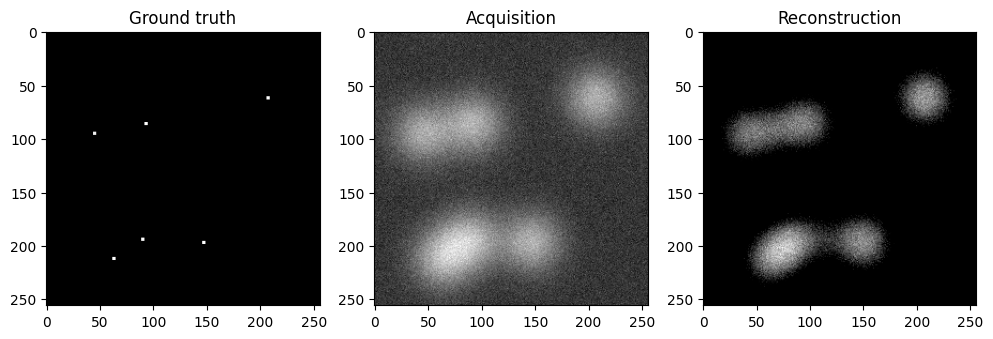

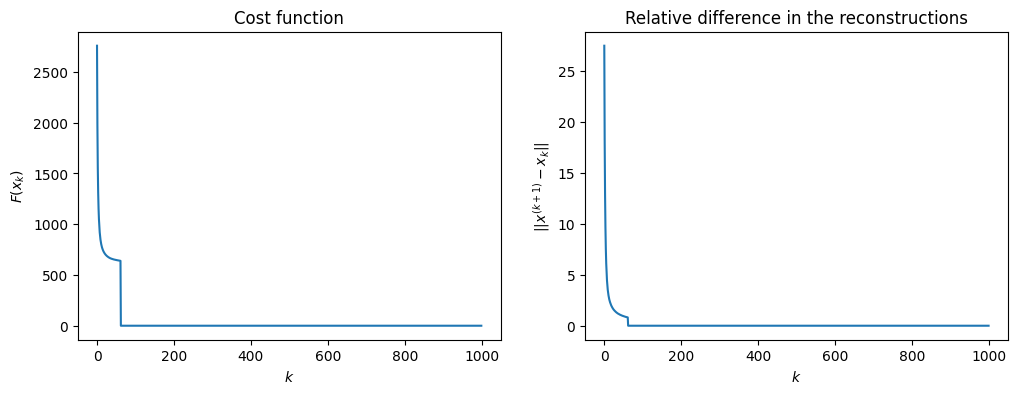

In [22]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 0.5
lmbda = 0.09
maxiter = 1000
epsilon = 0.001
alpha = 0.1 * np.random.randn(*dim)
beta = 7*np.pi


rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter, alpha, beta)
plot_results(rec, cost, norms)

>This proximal oparator remove the noise from Acquisition. But somehow it has limitation to get clear recunstruction than ISTA algorithm. Actually, this proximal operator is same with 
>$$ prox_{\tau\mathcal{R}}(x) = prox_{\tau\|·\|_1}(x − \tau \alpha)$$
>Thus, it represents the reconstuction with soft thresholding as much as $\tau \alpha$ subtracted from x (If $\alpha$ is close to zero, it returns same results with previous soft thresholding operator)

* What is the impact of $\beta$ on the reconstruction?

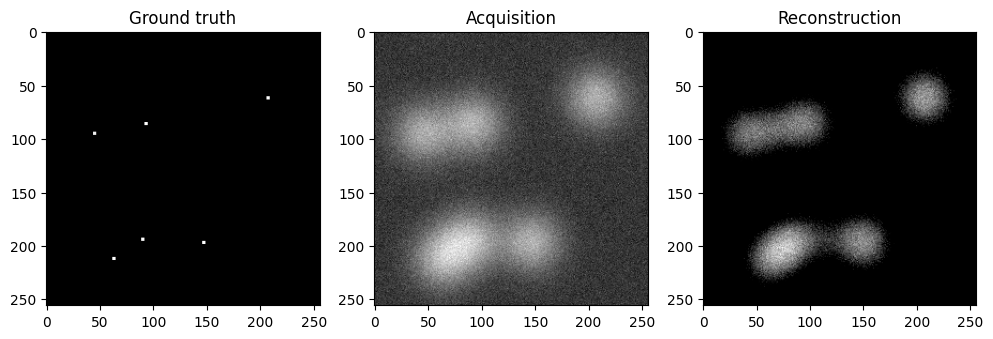

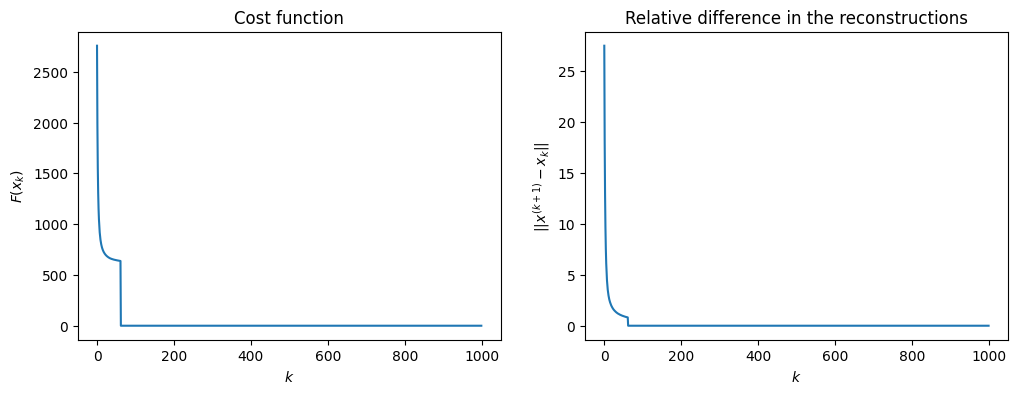

In [23]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 0.5
lmbda = 0.09
maxiter = 1000
epsilon = 0.001
# alpha = alpha_
beta = 0


rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter, alpha, beta)
plot_results(rec, cost, norms)

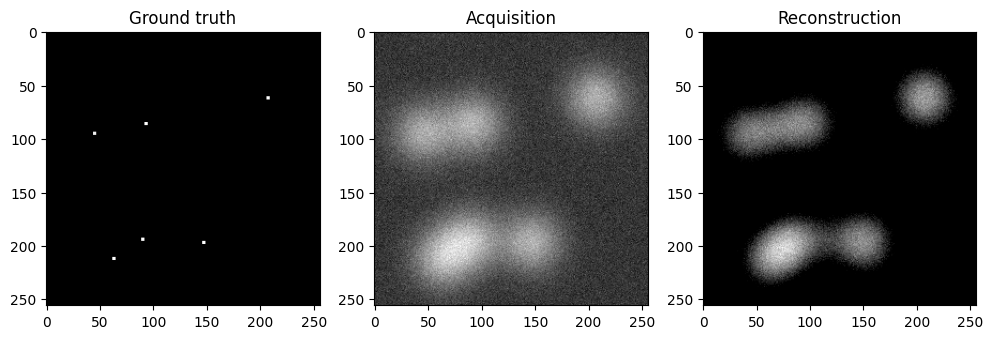

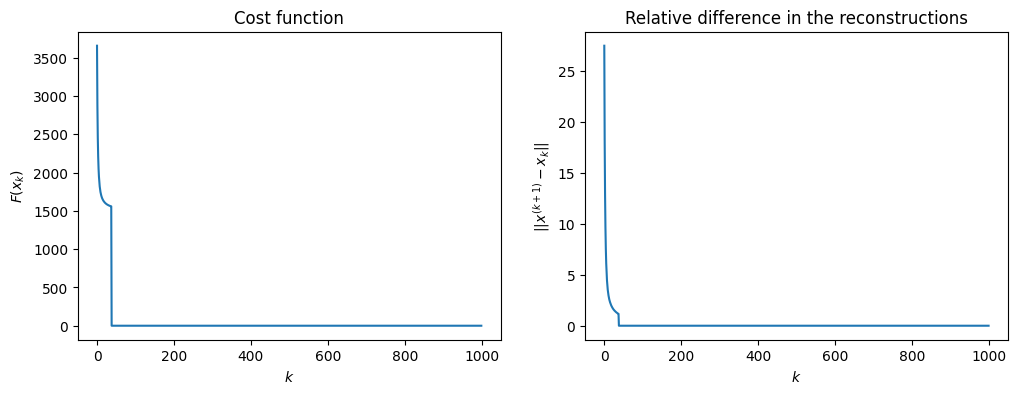

In [24]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 0.5
lmbda = 0.09
maxiter = 1000
epsilon = 0.001
# alpha = alpha_
beta = 10000


rec, cost, norms = FB(x0, tau, lmbda, acq, h, epsilon, maxiter, alpha, beta)
plot_results(rec, cost, norms)

> Higher values of $\beta$ tend to encourage sparser solutions by penalizing larger values of $x$. A higher $\beta$ value results in a stronger bias towards smaller values of  $x$, potentially leading to more elements being shrunk to zero during the regularization process. Lower values of $\beta$ relax the penalty on large values of $x$, allowing for less sparsity in the reconstructed solution. 
>
> Meanwhile, when comparing the results with our current parameters, the influence of $\beta$ appears to be relatively insignificant.